Across the 3 feature spaces searched (all features (19638), those features that are present in the Cancer Cell Map) we will have 3x(25 choose 2) = 900 total interactions. 

We want to further filter these interactions according to effect size and significance. Since our genetic algorithm optimized for fitness using the t-statistic, we need alternative calculations of statistical significance. 

In [129]:
import os
import itertools
import random
from multiprocessing import Pool
from math import comb
import copy

from tqdm import tqdm, trange 

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt 

import sys
sys.path.insert(1, '../../')
from utils import read_pickled_object

In [4]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 80
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

# Preprocess

Same as [Notebook 05A](./05A_top_ranked_interactions.ipynb)

In [5]:
# load data
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
expr_joint = X.copy()

mp_joint=pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean']
y = mp_joint.values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

# fit model
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))

model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)
model_coefs['rank'] = model_coefs.shape[0]


X = (X_protein, X_rna)
best_pipeline.fit(X, y)

# get prediction
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

# center
X_map = {'Transcriptomics': X_rna, 'Proteomics': X_protein}
X_map = {k: X_ - np.mean(X_, axis=0) for k, X_ in X_map.items()} # center the data

In [6]:
def get_interaction_value_ols(feature_1: str, feature_2: str, residuals, X_map, model_coefs):
    X_1 = X_map[model_coefs.loc[feature_1,'Modality']][:, model_coefs.loc[feature_1, 'feature_index']]
    X_2 = X_map[model_coefs.loc[feature_2,'Modality']][:, model_coefs.loc[feature_2, 'feature_index']]

    ols_df = pd.DataFrame({"residual": residuals, 
                           "X_tilda": X_1 * X_2})

    ols_interaction = smf.ols("residual ~ X_tilda", data=ols_df).fit()


    coef = float(ols_interaction.params.X_tilda)
    pval = float(ols_interaction.pvalues.X_tilda)
    
    se = ols_interaction.bse.X_tilda
    
    t_statistic = float(abs(coef))/se
    
    return coef, pval, t_statistic

Let's see how the genetic algorithm looked for each feature set:

In [9]:
fn_map = {'all': '', 
          'cancer_gene_consensus': 'cgc', 
          'cancer_cell_map': 'ccm'}

In [14]:
ols_scores_ga = {}
ols_best_set = {}

for feature_type, fn in fn_map.items():
    fn= 'v2' + fn
    score_tracker = pd.read_csv(os.path.join(data_path, 'processed', 'joint_interaction_residuals_ga_scores_sets' + fn + '.csv'), 
                               index_col = 0)
    with open(os.path.join(data_path, 'interim', 'joint_interaction_residuals_ga_solution_sets' + fn + '.txt'), "r") as f:
        best_set = [line.strip() for line in f]

    # if not v2:
    #     if not np.allclose(evaluate_solution(best_set), 
    #                        score_tracker.max().max()):
    #         raise ValueError('The best set is incongruous with the final generation')

    ols_scores_ga[feature_type] = score_tracker
    ols_best_set[feature_type] = best_set

    print("Best score for " + feature_type + ": {:.4f}".format(score_tracker.max().max()))


Best score for all: 0.5441
Best score for cancer_gene_consensus: 0.4163
Best score for cancer_cell_map: 0.4584


''

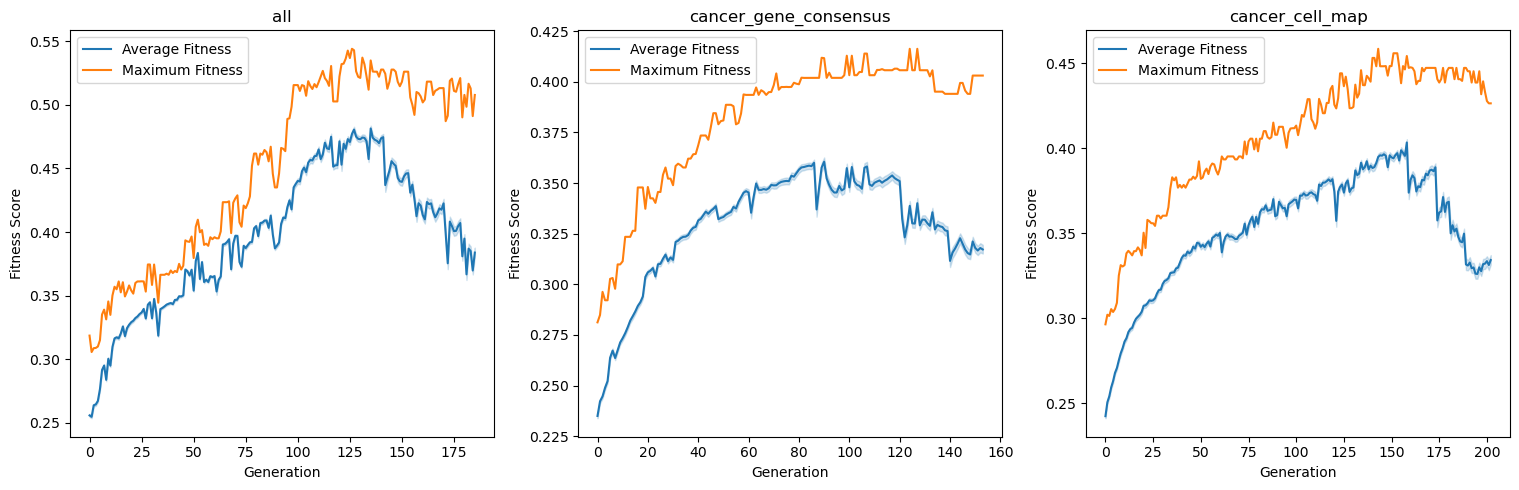

In [17]:
ncols = len(ols_scores_ga)
fig , ax = plt.subplots(ncols = ncols, figsize = (5.1*ncols,5))

for i, (feature_type, score_tracker) in enumerate(ols_scores_ga.items()):
    viz_df = score_tracker.copy()
    viz_df['generation'] = range(viz_df.shape[0])
    viz_df = pd.melt(viz_df, id_vars='generation', value_name='fitness_score')
    sns.lineplot(data = viz_df, x = 'generation', y = 'fitness_score', label = 'Average Fitness', ax = ax[i])

    viz_df = pd.DataFrame(score_tracker.max(axis = 1), columns = ['fitness_score'])
    viz_df.reset_index(names = 'generation', inplace = True)
    sns.lineplot(data = viz_df, x = 'generation', y = 'fitness_score', label = 'Maximum Fitness', ax = ax[i])
    ax[i].set_ylabel('Fitness Score')
    ax[i].set_xlabel('Generation')
    
    ax[i].set_title(feature_type)
    
fig.tight_layout()
;


Next, let's get the interactions from the OLS methodology for each set:

In [62]:
ols_res = pd.DataFrame(columns = ['feature_1', 'feature_2', 'coef', 'pval', 't_statistic', 'feature_type'])
for feature_type, best_set in ols_best_set.items():
    feature_combs = list(itertools.combinations(best_set, 2))

    res_all = []
    for feature_comb in tqdm(feature_combs):
        res = get_interaction_value_ols(feature_comb[0], feature_comb[1], residuals, X_map, model_coefs)
        res_all.append(res)

    res_all = pd.DataFrame(res_all, columns = ['coef', 'pval', 't_statistic'])
    _, bh_fdr, _, _ = multipletests(res_all.pval, method='fdr_bh')
    res_all['bh_fdr'] = bh_fdr

    res_all = pd.concat([
        pd.DataFrame(feature_combs, columns = ['feature_1', 'feature_2']),
        res_all
    ],
        axis = 1)
    
    res_all['feature_type'] = feature_type
    
    ols_res = pd.concat([ols_res, res_all], axis = 0)

100%|██████████████████████████████████████████| 300/300 [00:01<00:00, 173.25it/s]
/tmp/ipykernel_3825157/2619166151.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ols_res = pd.concat([ols_res, res_all], axis = 0)
100%|██████████████████████████████████████████| 300/300 [00:01<00:00, 173.47it/s]


Let's see how the t-statistic vs coefficient contributed to thes score:

''

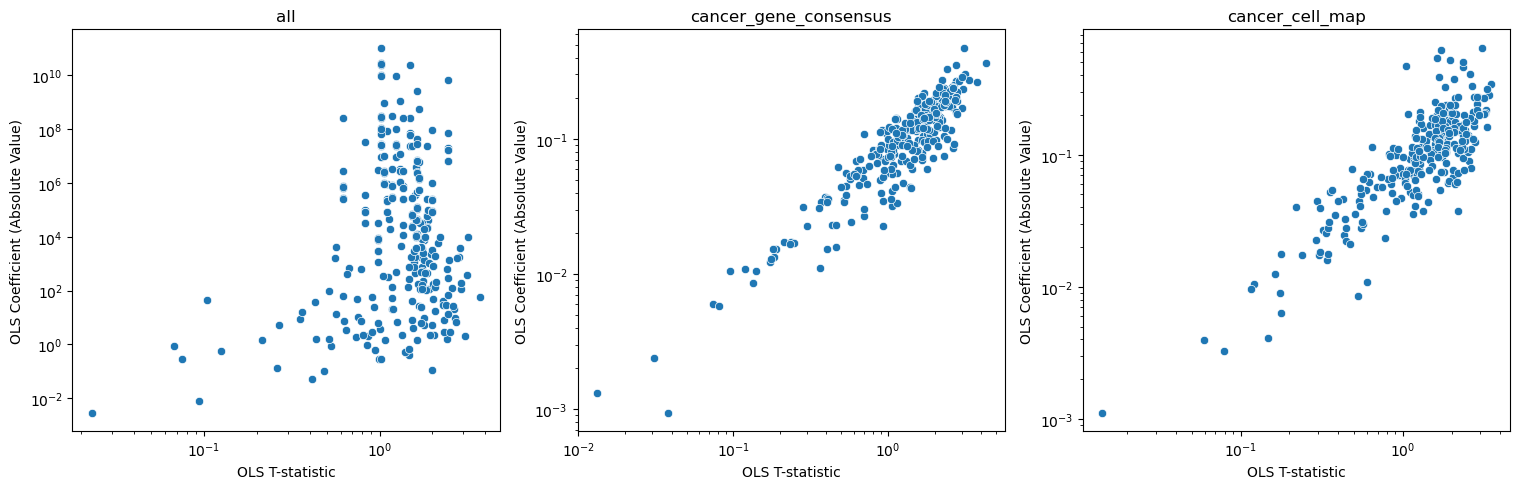

In [25]:
ncols = ols_res.feature_type.nunique()
fig, ax = plt.subplots(ncols = ncols, nrows = 1, figsize = (5.1*ncols, 5))

for i, feature_type in enumerate(ols_res.feature_type.unique()):
    viz_df = ols_res[ols_res.feature_type == feature_type]

    sns.scatterplot(y = viz_df.coef.abs(), x = viz_df.t_statistic, ax = ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    
    ax[i].set_ylabel('OLS Coefficient (Absolute Value)')
    ax[i].set_xlabel('OLS T-statistic')
    
    ax[i].set_title(feature_type)

fig.tight_layout()
;

We can see that when searching across all features, we identified some coefficients with very strong effect sizes, but that potentially also have high standard errors. In the cancer gene sets, effect sizes and t-statistics were more comparable. Each of these has their own value, which is why we weighted both components in the genetic algorithm. 

# Filter 

Next, let's filter for our most promising interactions across the three sets:

In [69]:
ols_res[ols_res.bh_fdr <= 0.15].feature_type.value_counts()

feature_type
cancer_cell_map          50
cancer_gene_consensus    27
all                       1
Name: count, dtype: int64

In [70]:
ols_res[ols_res.bh_fdr <= 0.2].feature_type.value_counts()

feature_type
cancer_cell_map          115
cancer_gene_consensus     81
all                       29
Name: count, dtype: int64

Based on the above significance thresholds, we retain only those interactions in cancer cell map or cancer gene consensus with a BH FDR <= 0.15, and those searched across all features with a BH FDR <= 0.2

In [71]:
ols_res = ols_res[((ols_res.feature_type.isin(['cancer_cell_map', 'cancer_gene_consensus'])) & (ols_res.bh_fdr <= 0.15)) |
       ((ols_res.feature_type.isin(['all'])) & (ols_res.bh_fdr <= 0.2))]

ols_res.feature_type.value_counts()

feature_type
cancer_cell_map          50
all                      29
cancer_gene_consensus    27
Name: count, dtype: int64

In [72]:
ols_res = ols_res.sort_values(by='t_statistic', key=lambda x: x.abs(), ascending=False)


''

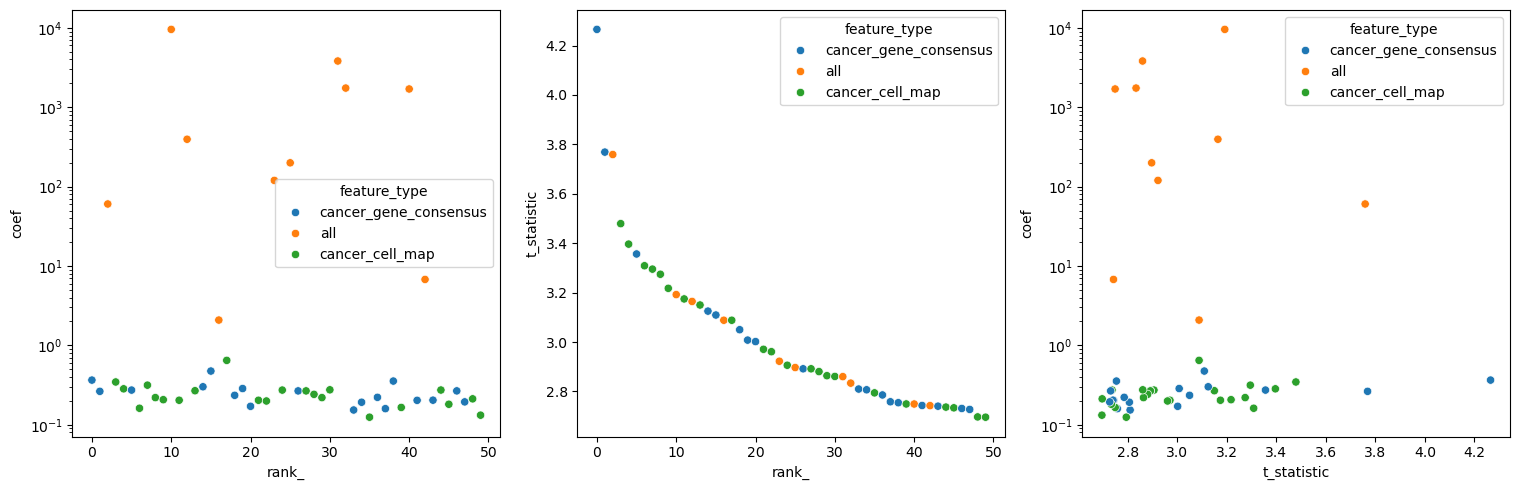

In [92]:
fig, ax = plt.subplots(ncols = 3, figsize = (15.3, 5))

viz_df = ols_res.copy()
viz_df['rank_'] = range(viz_df.shape[0])
viz_df['coef'] = viz_df.coef.abs()

sns.scatterplot(data = viz_df, x = 'rank_', y = 'coef', hue = 'feature_type', ax = ax[0])
ax[0].set_yscale('log')
sns.scatterplot(data = viz_df, x = 'rank_', y = 't_statistic', hue = 'feature_type', ax = ax[1])
sns.scatterplot(data = viz_df, x = 't_statistic', y = 'coef', hue = 'feature_type', ax = ax[2])
ax[2].set_yscale('log')

fig.tight_layout()
;

Upon rank ordering by t-statistics, we can see that those with the largest effect sizes (absolute value of coefficient) do not necessarily have the largest t-statistics. This tells us that sometimes those values with large effect sizes also have large standard errors. Thus, of our remaining 106 interactions, we will heuristically take the top 50 to examine further. 

In [86]:
ols_res = ols_res.iloc[:50, :].reset_index(drop=True)
ols_res.feature_type.value_counts()

feature_type
cancer_cell_map          22
cancer_gene_consensus    18
all                      10
Name: count, dtype: int64

''

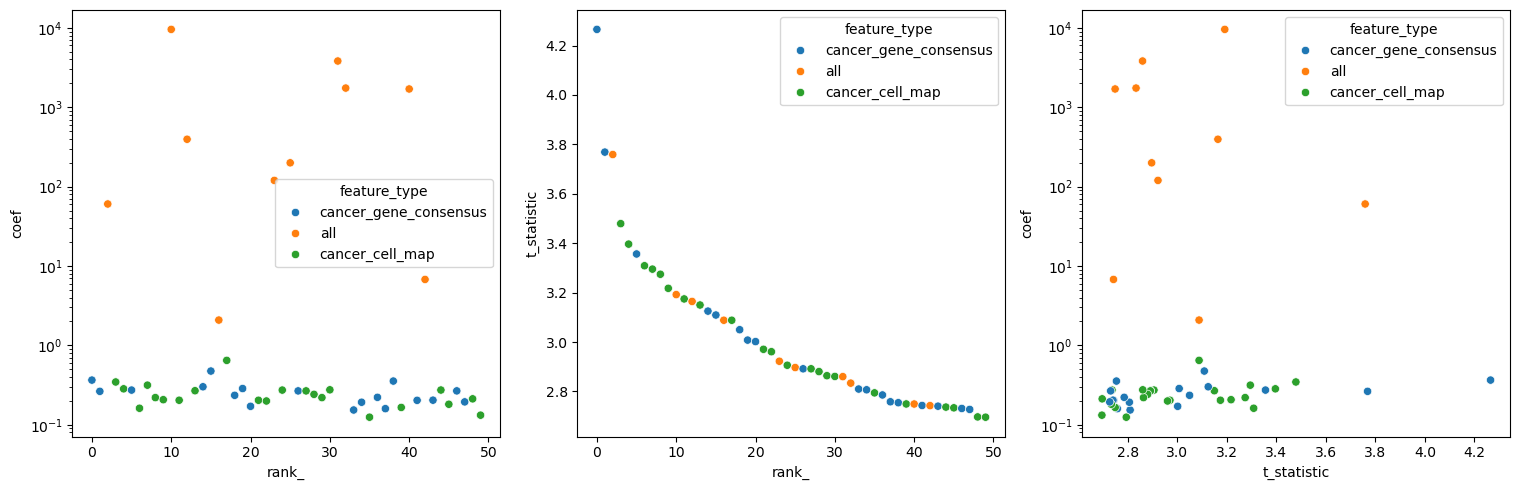

In [91]:
fig, ax = plt.subplots(ncols = 3, figsize = (15.3, 5))

viz_df = ols_res.copy()
viz_df['rank_'] = range(viz_df.shape[0])
viz_df['coef'] = viz_df.coef.abs()

sns.scatterplot(data = viz_df, x = 'rank_', y = 'coef', hue = 'feature_type', ax = ax[0])
ax[0].set_yscale('log')
sns.scatterplot(data = viz_df, x = 'rank_', y = 't_statistic', hue = 'feature_type', ax = ax[1])
sns.scatterplot(data = viz_df, x = 't_statistic', y = 'coef', hue = 'feature_type', ax = ax[2])
ax[2].set_yscale('log')

fig.tight_layout()
;

This filtering approach prioritized significant interactions from the OLS over those with strong effects, while maintaining a reasonable balance of having some strong effect interactions (particularly from the all gene set) and a reasonable number of interactions from each of the 3 searched gene sets. 

In [ ]:
ols_res.to_csv(os.path.join(data_path, 'interim', 'filtered_ols_interactions.csv'))

# Assess Significance: Permutation Test

Since we used the t-statistic as part of the fitness score in the genetic algorithm, we cannot directly use these p-values to assess the significance of the interaction. Thus, we use an alternative permutation test to assess signifiance. 

Amongst our list of 50 interactions, we will retain those with a BH FDR <= 0.1 for further exploration. 

In [101]:
# re-load data
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.set_index('feature_name', inplace = True)

ols_res = pd.read_csv(os.path.join(data_path, 'interim', 'filtered_ols_interactions.csv'), 
                     index_col = 0)

1) Get the selected features from the fit on the full dataset and union of modalities. 
This is different from the 10-fold CV, where feature selection is run each time. We will use 10-fold CV, but on this consistent set of features which we are interested in testing interactions for. 

In [102]:
X_map_selected = {}
for modality, X in X_map.items():
    modality_indices = model_coefs[model_coefs.Modality == modality]['feature_index'].values # selected_indices[modality]
    X_map_selected[modality] = X[:, modality_indices]

X_selected = np.concatenate([X_map_selected['Proteomics'], X_map_selected['Transcriptomics']], 
               axis = 1)


2. Sanity check -- does fitting the model on this manual pipeline match the automated best_pipeline?

In [103]:
svr_model = copy.deepcopy(best_pipeline.named_steps['model'])

In [104]:
svr_model.fit(X_selected, y)
model_coefs_check = pd.DataFrame(data = {'SVM coefficient': svr_model.coef_.ravel()})
model_coefs_check['feature_name'] = model_coefs.index.tolist()#selected_protein_cols + selected_rna_cols
model_coefs_check.set_index('feature_name', inplace = True)

if not np.allclose(model_coefs_check['SVM coefficient'].values, #model_coefs_check.loc[model_coefs.index,:]['SVM coefficient'].values, 
                   model_coefs['SVM coefficient'].values):
    raise ValueError('Something in the manual processing pipeline does not match the automated best_pipeline')
    
else:
    model_coefs['feature_index_selected'] = range(model_coefs.shape[0])
    model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)

3. Run the permutation test:

In [164]:
def get_interaction_value_permutation(feature_1, 
                                      feature_2, 
                                      n_perm,
                                      y = y,
                                      random_state = random_state, 
                                      svr_model = svr_model, 
                                      X_selected = X_selected, 
                                      model_coefs = model_coefs):
    X_interaction = X_selected.copy()

    feature_1_index = model_coefs.loc[feature_1, 'feature_index_selected']
    feature_2_index = model_coefs.loc[feature_2, 'feature_index_selected']
    interaction = X_selected[:, feature_1_index]*X_selected[:, feature_2_index]

    X_interaction = np.concatenate([X_interaction, interaction.reshape(-1, 1)], axis = 1)

    svr_model.fit(X_interaction, y)
    interaction_coef = svr_model.coef_[0, -1]

    np.random.seed(random_state)

    permuted_coefs = []
    for _ in range(n_perm):  
        y_perm = np.random.permutation(y)
        svr_model.fit(X_interaction, y_perm)

        permuted_coefs.append(svr_model.coef_[0, -1])

    # fraction of time permuted coefficients are greater than the interaction
    pval = np.mean(np.abs(permuted_coefs) >= np.abs(interaction_coef)) 
    
    return feature_1, feature_2, interaction_coef, pval

In [150]:
print('Start permutation testing')

Start permutation testing


In [151]:
feature_combs = [(ols_res.loc[i, 'feature_1'], ols_res.loc[i, 'feature_2']) for i in ols_res.index]
n_perm = 1000

if n_cores in [0, 1, None]:
    res_all = []
    for feature_comb in tqdm(feature_combs):
        res = get_interaction_value_permutation(feature_1 = feature_comb[0], 
                                    feature_2 = feature_comb[1],
                                    n_perm = n_perm,
                                    y = y,
                                    random_state = random_state,
                                    svr_model = svr_model,
                                    X_selected = X_selected,
                                    model_coefs = model_coefs)
        res_all.append(res)
else:
    feature_combs_sm = [(f1, f2, n_perm) for (f1, f2) in feature_combs]
    n_cores_ = min(n_cores, len(feature_combs))
    with Pool(processes=n_cores_) as pool:
        res_all = pool.starmap(get_interaction_value_permutation, feature_combs_sm)
    
    
#     from functools import partial
#     feature_combs_args = [(f1, f2, n_perm) for f1, f2 in feature_combs]
#     func = partial(get_interaction_value_permutation,
#                    y=y,
#                    random_state=random_state,
#                    svr_model=svr_model,
#                    X_selected=X_selected,
#                    model_coefs=model_coefs)

#     # Define top-level helper for unpacking
#     def unpack_and_run(args, func):
#         return func(*args)

#     # Prepare wrapper with pre-filled `func`
#     unpack_func = partial(unpack_and_run, func=func)

#     # Use multiprocessing with progress bar
#     n_cores_ = min(n_cores, len(feature_combs))
#     with Pool(processes=n_cores_) as pool:
#         res_all = list(tqdm(pool.imap(unpack_func, feature_combs_args),
#                             total=len(feature_combs_args)))


    

res_all = pd.DataFrame(res_all, columns = ['feature_1', 'feature_2', 'coef', 'pval'])
_, bh_fdr, _, _ = multipletests(res_all.pval, method='fdr_bh')
res_all['bh_fdr'] = bh_fdr
res_all.to_csv(os.path.join(data_path, 'interim', 'joint_interaction_permutation.csv'))